<a href="https://colab.research.google.com/github/sree-vg/DS_Clickstream-customer-conversion/blob/main/customer_click_stream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CUSTOMER CONVERSION ANALYSIS FOR ONLINE SHOPPING

In [1]:
!pip install scikit-learn xgboost lightgbm


Import Libraries

In [2]:
# ===============================
# Core Libraries
# ===============================
import os
import io
import warnings
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")
np.random.seed(42)   # ✅ RANDOM SEED (GLOBAL)

# ===============================
# Visualization
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# Google Colab
# ===============================
from google.colab import files

# ===============================
# Scikit-learn
# ===============================
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    mean_squared_error, r2_score, silhouette_score
)

# ===============================
# Classification Models
# ===============================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# ===============================
# Regression Models
# ===============================
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# ===============================
# Clustering
# ===============================
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score

# ===============================
# Imbalanced Learning
# ===============================
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# ===============================
# Model Persistence
# ===============================
import joblib
import pickle
import shutil



Load Dataset

In [3]:
uploaded = files.upload()

file_names = list(uploaded.keys())

train_file = [f for f in file_names if "train" in f.lower()][0]
test_file  = [f for f in file_names if "test" in f.lower()][0]

train_df = pd.read_csv(io.BytesIO(uploaded[train_file]))
test_df  = pd.read_csv(io.BytesIO(uploaded[test_file]))

print("Train file loaded:", train_file)
print("Test file loaded:", test_file)

print("✅ Train shape:", train_df.shape)
print("✅ Test shape:", test_df.shape)
print("\nColumns in train:", train_df.columns.tolist())
print("\nColumns in test:", test_df.columns.tolist())
train_df.head()

Saving test_data.csv to test_data.csv
Saving train_data.csv to train_data.csv
Train file loaded: train_data.csv
Test file loaded: test_data.csv
✅ Train shape: (132379, 14)
✅ Test shape: (33095, 14)

Columns in train: ['year', 'month', 'day', 'order', 'country', 'session_id', 'page1_main_category', 'page2_clothing_model', 'colour', 'location', 'model_photography', 'price', 'price_2', 'page']

Columns in test: ['year', 'month', 'day', 'order', 'country', 'session_id', 'page1_main_category', 'page2_clothing_model', 'colour', 'location', 'model_photography', 'price', 'price_2', 'page']


,year,month,day,order,country,session_id,page1_main_category,page2_clothing_model,colour,location,model_photography,price,price_2,page
0,2008,6,22,21,29,15648,3,C20,13,1,2,48,1,2
1,2008,5,19,6,29,10018,2,B26,13,3,1,57,1,2
2,2008,7,15,2,29,19388,3,C13,9,5,1,48,1,1
3,2008,5,2,2,29,7181,2,B11,2,4,1,43,2,1
4,2008,6,9,16,29,13493,2,B31,9,5,1,57,1,2


In [4]:
train_df.describe()

train_df.dtypes

,0
year,int64
month,int64
day,int64
order,int64
country,int64
session_id,int64
page1_main_category,int64
page2_clothing_model,object
colour,int64
location,int64


In [5]:
train_df.isnull().sum()
test_df.isnull().sum()

,0
year,0
month,0
day,0
order,0
country,0
session_id,0
page1_main_category,0
page2_clothing_model,0
colour,0
location,0


Standardize Column Names

In [6]:
def clean_column_names(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    return df

train_df = clean_column_names(train_df)
test_df  = clean_column_names(test_df)

train_df.head()

,year,month,day,order,country,session_id,page1_main_category,page2_clothing_model,colour,location,model_photography,price,price_2,page
0,2008,6,22,21,29,15648,3,C20,13,1,2,48,1,2
1,2008,5,19,6,29,10018,2,B26,13,3,1,57,1,2
2,2008,7,15,2,29,19388,3,C13,9,5,1,48,1,1
3,2008,5,2,2,29,7181,2,B11,2,4,1,43,2,1
4,2008,6,9,16,29,13493,2,B31,9,5,1,57,1,2


Target Column Creation

In [7]:
def create_target(df):
    df["converted"] = (df["page"] >= 4).astype(int)
    return df

train_df = create_target(train_df)
train_df["converted"].value_counts()


,count
converted,
0,122989
1,9390


In [8]:
sns.set(style="whitegrid")

df = train_df.copy()
print(df.head())
print(df.info())
print(df.describe())


   year  month  day  order  country  session_id  page1_main_category  \
0  2008      6   22     21       29       15648                    3   
1  2008      5   19      6       29       10018                    2   
2  2008      7   15      2       29       19388                    3   
3  2008      5    2      2       29        7181                    2   
4  2008      6    9     16       29       13493                    2   

  page2_clothing_model  colour  location  model_photography  price  price_2  \
0                  C20      13         1                  2     48        1   
1                  B26      13         3                  1     57        1   
2                  C13       9         5                  1     48        1   
3                  B11       2         4                  1     43        2   
4                  B31       9         5                  1     57        1   

   page  converted  
0     2          0  
1     2          0  
2     1          0  
3     1 

Exploratory Data Analysis (EDA) & Feature Insights


---


Country Mapping for Top 10 Countries (Barplot)

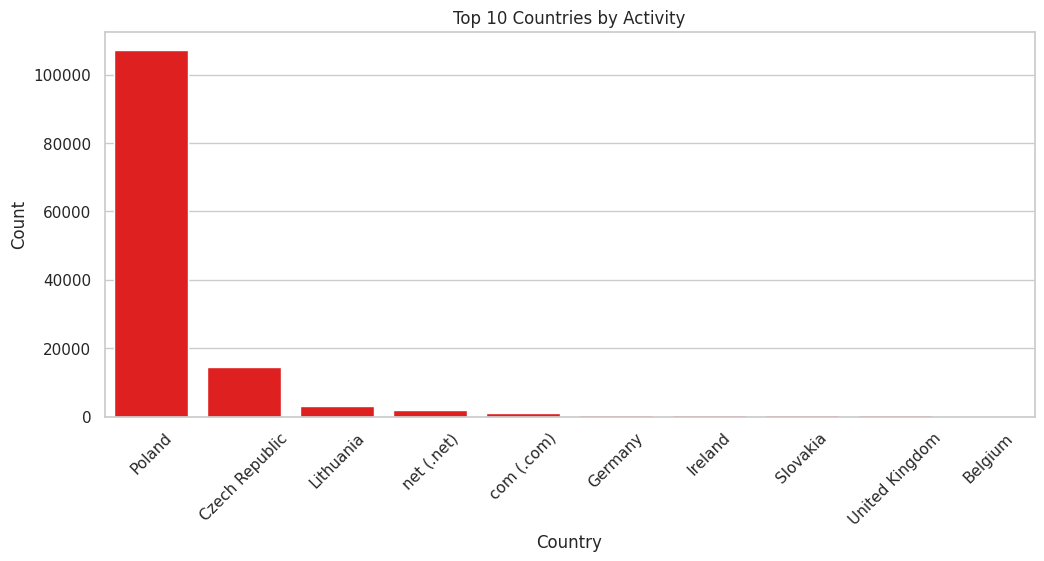

In [9]:
country_map = {
    '1': 'Australia','2': 'Austria','3': 'Belgium','4': 'British Virgin Islands','5': 'Cayman Islands',
    '6': 'Christmas Island','7': 'Croatia','8': 'Cyprus','9': 'Czech Republic','10': 'Denmark',
    '11': 'Estonia','12': 'Unidentified','13': 'Faroe Islands','14': 'Finland','15': 'France','16': 'Germany',
    '17': 'Greece','18': 'Hungary','19': 'Iceland','20': 'India','21': 'Ireland','22': 'Italy','23': 'Latvia',
    '24': 'Lithuania','25': 'Luxembourg','26': 'Mexico','27': 'Netherlands','28': 'Norway','29': 'Poland',
    '30': 'Portugal','31': 'Romania','32': 'Russia','33': 'San Marino','34': 'Slovakia','35': 'Slovenia',
    '36': 'Spain','37': 'Sweden','38': 'Switzerland','39': 'Ukraine','40': 'United Arab Emirates',
    '41': 'United Kingdom','42': 'USA','43': 'biz (.biz)','44': 'com (.com)',
    '45': 'int (.int)','46': 'net (.net)','47': 'org (*.org)'
}

train_df["country_name"] = train_df["country"].astype(str).map(country_map)

top20 = train_df["country_name"].value_counts().head(10)

plt.figure(figsize=(12,5))
sns.barplot(x=top20.index, y=top20.values, color='red')
plt.title("Top 10 Countries by Activity")
plt.xlabel("Country")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Product Mapping for Main category distribution

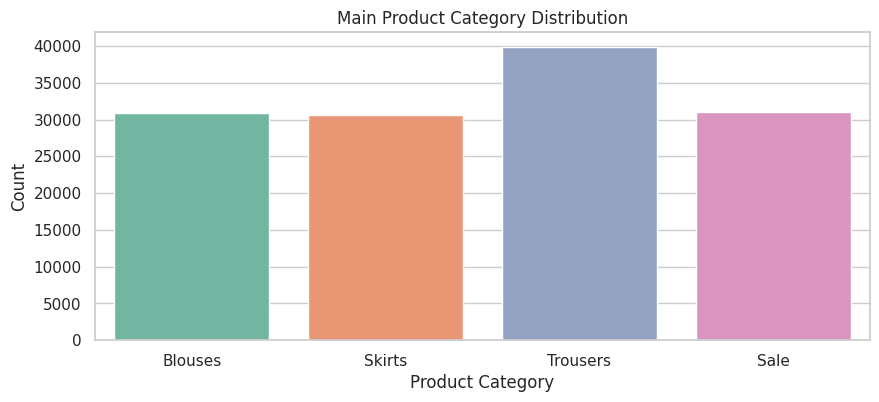

In [10]:
product_map = {1: 'Trousers', 2: 'Skirts', 3: 'Blouses', 4: 'Sale'}
train_df["main_product"] = train_df["page1_main_category"].map(product_map)

plt.figure(figsize=(10,4))
sns.countplot(x=train_df["main_product"], palette="Set2")
plt.title("Main Product Category Distribution")
plt.xlabel("Product Category")
plt.ylabel("Count")
plt.show()

Price Distribution(Histogram)

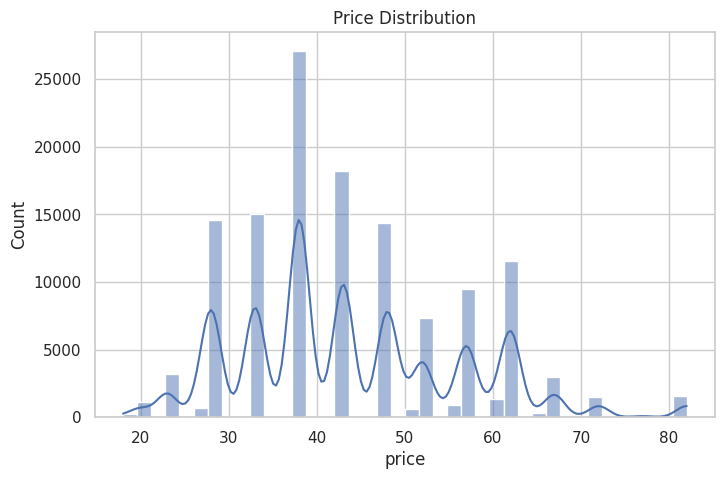

In [11]:
plt.figure(figsize=(8,5))
sns.histplot(train_df["price"], bins=40, kde=True)
plt.title("Price Distribution")
plt.show()

Price Log Distribution(Histogram)

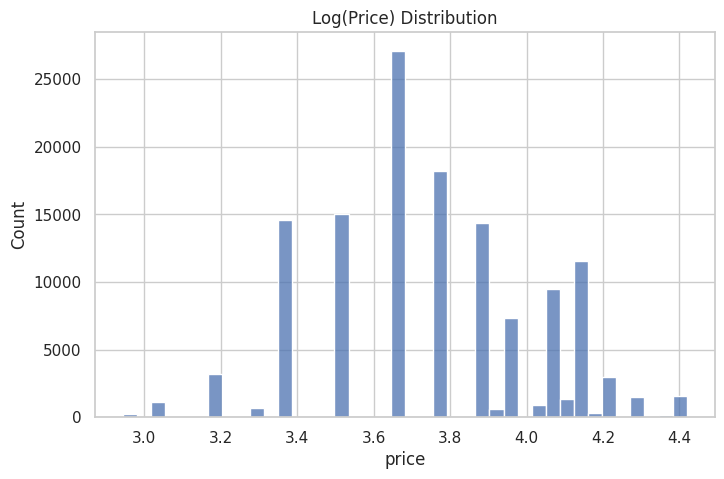

In [12]:
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(train_df["price"]), bins=40)
plt.title("Log(Price) Distribution")
plt.show()

Boxplot Price vs Country (Top 10)

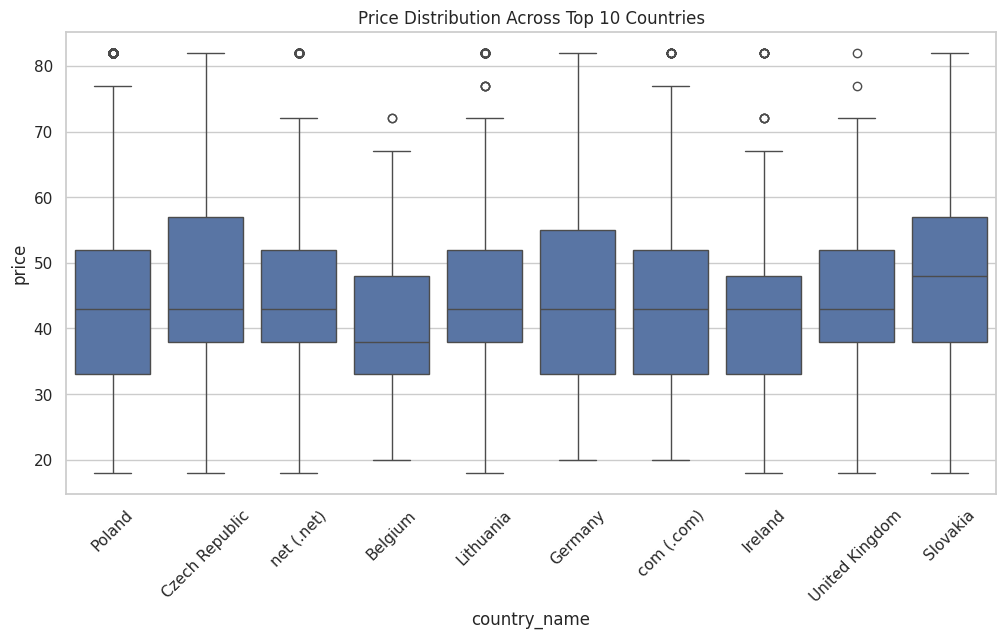

In [13]:
top_countries = train_df["country_name"].value_counts().head(10).index
filtered_df = train_df[train_df["country_name"].isin(top_countries)]

plt.figure(figsize=(12,6))
sns.boxplot(data=filtered_df, x="country_name", y="price")
plt.xticks(rotation=45)
plt.title("Price Distribution Across Top 10 Countries")
plt.show()



Correlation Heatmap

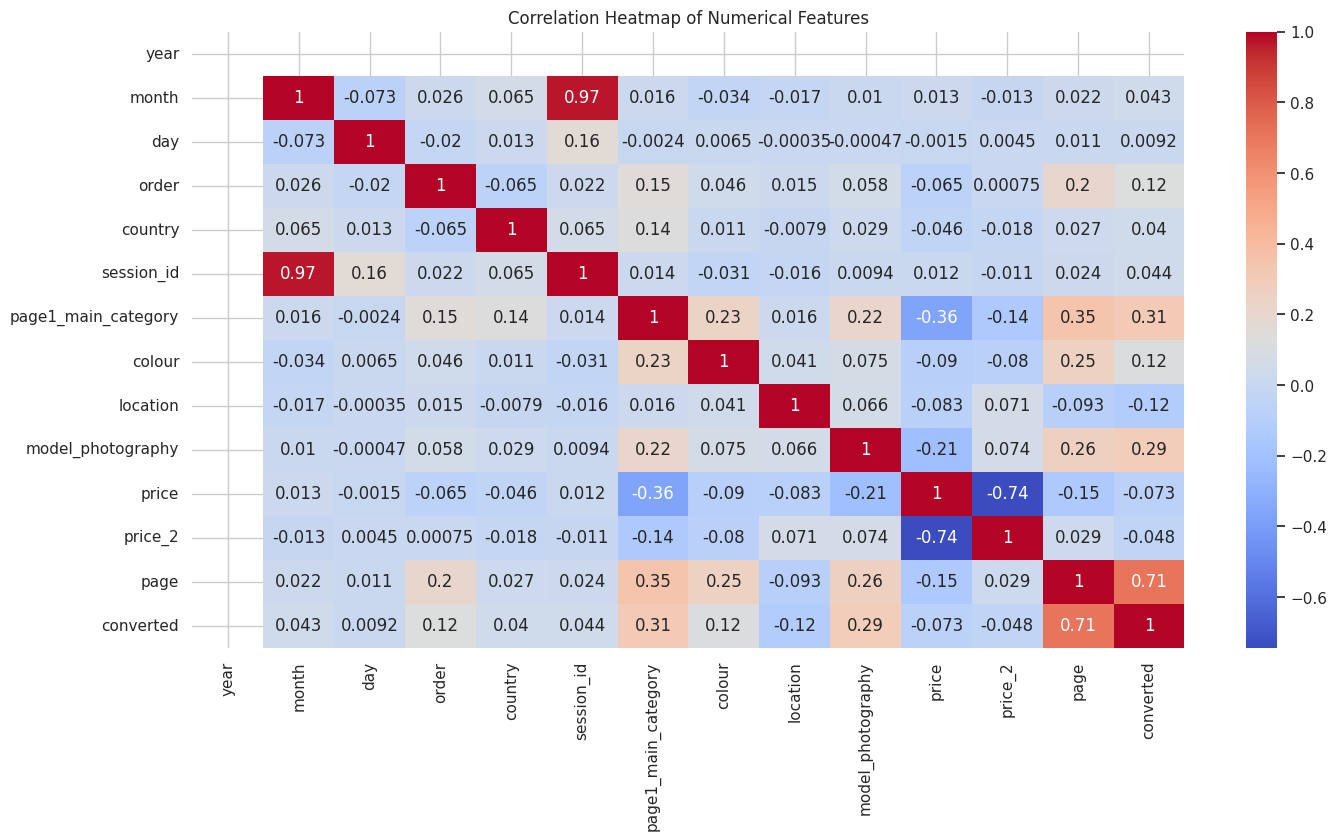

In [14]:
num = train_df.select_dtypes(exclude='object')

plt.figure(figsize=(16,8))
corr = num.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


In [15]:
#  CONNECT COLAB TO DAGSHUB MLFLOW

!pip install -q dagshub mlflow

import dagshub
import mlflow

dagshub.init(
    repo_owner="tstr12cg429",
    repo_name="Clickstream_classification",
    mlflow=True
)

print("✅ MLflow connected to DagsHub")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.3/261.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.7/774.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/2

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=734c5ec9-a905-4ae1-80aa-c0f1925c4976&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=6e917fafffbc3aef9da773687c98f9af6bcc64785239d1be2e6e6f48bc3f138a




Accessing as tstr12cg429

Initialized MLflow to track repo "tstr12cg429/Clickstream_classification"

Repository tstr12cg429/Clickstream_classification initialized!

✅ MLflow connected to DagsHub


Feature Engineering & Data Transformation



---

Classification Preprocessor

In [16]:
numeric_features = ["order"]

categorical_features = [
    "country",
    "country_name",
    "main_product",
    "page1_main_category",
    "page2_clothing_model",
    "colour",
    "location",
    "model_photography"
]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)


CLASSIFICATION PIPELINE

---
Train/Test Split


In [17]:
X = train_df.drop(
    ["converted", "price", "session_id","page"],
    axis=1,
    errors="ignore"
)

y = train_df["converted"]

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Train/Test split done")

import json
import mlflow
from sklearn.metrics import classification_report

feature_list = X.columns.tolist()

with open("features.json", "w") as f:
    json.dump(feature_list, f)

mlflow.log_artifact("features.json")

print("✅ Feature list saved & logged")


print("Before SMOTE:")
print(y_train.value_counts())

clf = LogisticRegression(max_iter=1000)

pipe = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", clf)
])

pipe.fit(X_train, y_train)

print("\nSMOTE applied INSIDE pipeline (resampling not visible externally)")
print("Original training distribution:")
print(y_train.value_counts())

preds = pipe.predict(X_val)
proba = pipe.predict_proba(X_val)[:, 1]

print("\nAccuracy:", accuracy_score(y_val, preds))
print("ROC AUC:", roc_auc_score(y_val, proba))
print("\nClassification Report:\n")
print(classification_report(y_val, preds))


✅ Train/Test split done
✅ Feature list saved & logged
Before SMOTE:
converted
0    98391
1     7512
Name: count, dtype: int64

SMOTE applied INSIDE pipeline (resampling not visible externally)
Original training distribution:
converted
0    98391
1     7512
Name: count, dtype: int64

Accuracy: 1.0
ROC AUC: 1.0

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24598
           1       1.00      1.00      1.00      1878

    accuracy                           1.00     26476
   macro avg       1.00      1.00      1.00     26476
weighted avg       1.00      1.00      1.00     26476



In [18]:
print(X_train.columns.tolist())


['year', 'month', 'day', 'order', 'country', 'page1_main_category', 'page2_clothing_model', 'colour', 'location', 'model_photography', 'price_2', 'country_name', 'main_product']


Train Multiple Classifiers

In [19]:
# Classification Models

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=42
    ),
    "XGB": XGBClassifier(
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42
    ),
    "LightGBM": LGBMClassifier(
        random_state=42,
        verbose=-1
    ),
    "MLP": MLPClassifier(
        max_iter=500,
        random_state=42
    )
}

# Model Evaluation Storage
best_auc = 0
best_classifier_pipe = None
best_model_name = None
results = {}


Model Benchmarking & Comparative Evaluation


In [20]:
for name, model in classifiers.items():
    print(f"\n🔹 Training {name} with SMOTE...")

    pipe = ImbPipeline([
        ("preprocess", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)

    preds = pipe.predict(X_val)
    proba = pipe.predict_proba(X_val)[:, 1]

    acc = accuracy_score(y_val, preds)
    prec = precision_score(y_val, preds)
    rec = recall_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    roc_auc = roc_auc_score(y_val, proba)
    cm = confusion_matrix(y_val, preds)

    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "ROC AUC": roc_auc,
        "Confusion Matrix": cm
    }

    if roc_auc > best_auc:
        best_auc = roc_auc
        best_classifier_pipe = pipe
        best_model_name = name

results_df = pd.DataFrame(results).T.drop(columns=["Confusion Matrix"])
print("\n📊 Model Performance:\n")
print(results_df.round(3))
print("🏆 Best Classification Model:", best_model_name)

import mlflow
import mlflow.sklearn

with mlflow.start_run(run_name="Classification_Pipeline", nested=True):


    mlflow.log_param("model_type", best_model_name)
    mlflow.log_metric("best_roc_auc", best_auc)

    mlflow.sklearn.log_model(
        best_classifier_pipe,
        artifact_path="classifier",
        registered_model_name="Best_Classifier"
    )

print("✅ Classification pipeline logged to MLflow")


import os

os.makedirs("/content/artifacts", exist_ok=True)

results_df.to_csv(
    "/content/artifacts/classification_results.csv",
    index=True
)




🔹 Training Logistic Regression with SMOTE...

🔹 Training Random Forest with SMOTE...

🔹 Training XGB with SMOTE...

🔹 Training LightGBM with SMOTE...

🔹 Training MLP with SMOTE...

📊 Model Performance:

                    Accuracy Precision Recall F1 Score ROC AUC
Logistic Regression      1.0       1.0    1.0      1.0     1.0
Random Forest            1.0       1.0    1.0      1.0     1.0
XGB                      1.0       1.0    1.0      1.0     1.0
LightGBM                 1.0       1.0    1.0      1.0     1.0
MLP                      1.0       1.0    1.0      1.0     1.0
🏆 Best Classification Model: Logistic Regression


2025/12/20 15:22:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'Best_Classifier' already exists. Creating a new version of this model...
2025/12/20 15:23:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Best_Classifier, version 5
Created version '5' of model 'Best_Classifier'.


🏃 View run Classification_Pipeline at: https://dagshub.com/tstr12cg429/Clickstream_classification.mlflow/#/experiments/0/runs/1bce5f96055545269f9570fcc22289aa
🧪 View experiment at: https://dagshub.com/tstr12cg429/Clickstream_classification.mlflow/#/experiments/0
✅ Classification pipeline logged to MLflow


ROC–AUC Performance Analysis


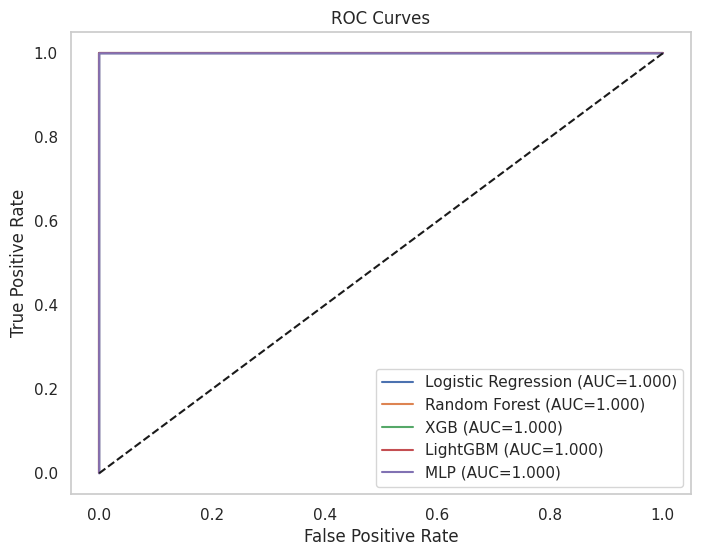

Average Precision (PR-AUC): 1.0


In [21]:
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(8, 6))

for name, model in classifiers.items():
    pipe = ImbPipeline([
        ("preprocess", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)

    if hasattr(pipe, "predict_proba"):
        proba = pipe.predict_proba(X_val)[:, 1]
    else:
        continue

    fpr, tpr, _ = roc_curve(y_val, proba)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid()
plt.show()

from sklearn.metrics import average_precision_score

ap_score = average_precision_score(y_val, proba)
print("Average Precision (PR-AUC):", round(ap_score, 4))



VERFICATION

In [22]:
pd.Series(best_classifier_pipe.named_steps["model"].feature_importances_
          if hasattr(best_classifier_pipe.named_steps["model"], "feature_importances_")
          else np.abs(best_classifier_pipe.named_steps["model"].coef_[0])
         ).sort_values(ascending=False).head(10)


,0
225,9.946800
226,9.329739
317,8.685800
285,8.458556
296,8.302939
298,8.277399
313,7.934791
312,7.699114
284,7.490783
300,7.490688


In [23]:
# Get feature names after preprocessing
preprocessor = best_classifier_pipe.named_steps["preprocess"]

feature_names = preprocessor.get_feature_names_out()

importances = (
    best_classifier_pipe.named_steps["model"].feature_importances_
    if hasattr(best_classifier_pipe.named_steps["model"], "feature_importances_")
    else np.abs(best_classifier_pipe.named_steps["model"].coef_[0])
)

feat_imp_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .head(15)
)

feat_imp_df


,feature,importance
225,cat__page2_clothing_model_C55,9.946800
226,cat__page2_clothing_model_C56,9.329739
317,cat__colour_3,8.685800
285,cat__page2_clothing_model_P57,8.458556
296,cat__page2_clothing_model_P67,8.302939
298,cat__page2_clothing_model_P69,8.277399
313,cat__page2_clothing_model_P82,7.934791
312,cat__page2_clothing_model_P81,7.699114
284,cat__page2_clothing_model_P56,7.490783
300,cat__page2_clothing_model_P70,7.490688


In [24]:
df.columns

Index(['year', 'month', 'day', 'order', 'country', 'session_id',
       'page1_main_category', 'page2_clothing_model', 'colour', 'location',
       'model_photography', 'price', 'price_2', 'page', 'converted'],
      dtype='object')

REGRESSION PIPELINE

---

Regression Modeling


In [25]:
num_features = ["year", "month", "day", "order", "page"]

cat_features = [
    "country", "session_id", "page1_main_category",
    "page2_clothing_model", "colour", "location",
    "model_photography", "country_name", "main_product"
]

preprocessor_reg = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])


In [26]:
regressors = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(
        n_estimators=300,
        random_state=42
    ),
    "XGBoost": XGBRegressor(
        random_state=42
    ),
    "LightGBM": LGBMRegressor(
        random_state=42,
        verbose=-1
    )
}

target = "price"
X = train_df.drop(
    ["converted", "price"],
    axis=1,
    errors="ignore"
)
y = train_df[target]

X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(
    X, y, test_size=0.2, random_state=42
)

regression_results = {}

best_r2 = -np.inf
best_regression_pipe = None
best_reg_name = None


for name, model in regressors.items():
    print(f"\n🔹 Training {name}...")

    pipe = Pipeline([
        ("preprocess", preprocessor_reg),
        ("model", model)
    ])

    pipe.fit(X_train_reg, y_train_reg)
    preds = pipe.predict(X_val_reg)

    rmse = np.sqrt(mean_squared_error(y_val_reg, preds))
    r2 = r2_score(y_val_reg, preds)

    regression_results[name] = {"RMSE": rmse, "R2": r2}

    # ⭐ Track best regression model
if r2 > best_r2:
    best_r2 = r2
    best_regression_pipe = pipe
    best_reg_name = name

    print(f"{name} → RMSE: {rmse:.3f}, R²: {r2:.3f}")

results_df = pd.DataFrame(regression_results).T
print("\n📊 Final Regression Results:")
print(results_df)

results_df.to_csv(
    "/content/artifacts/regression_results.csv"
)

print("🏆 Best Regression Model:", best_reg_name)





🔹 Training Linear Regression...

🔹 Training Random Forest...

🔹 Training XGBoost...

🔹 Training LightGBM...
LightGBM → RMSE: 0.560, R²: 0.998

📊 Final Regression Results:
                       RMSE        R2
Linear Regression  0.002068  1.000000
Random Forest      0.051179  0.999983
XGBoost            1.305098  0.989254
LightGBM           0.560126  0.998021
🏆 Best Regression Model: LightGBM


In [27]:
# MLFLOW LOGGING — REGRESSION (DAGsHub)

import mlflow
import mlflow.sklearn

best_reg_name = results_df["R2"].idxmax()

with mlflow.start_run(
    run_name="Regression_Pipeline",
    nested=True
):
    mlflow.log_param("model_type", best_reg_name)
    mlflow.log_metric("best_r2", results_df["R2"].max())

    mlflow.sklearn.log_model(
        sk_model=best_regression_pipe,
        artifact_path="regressor",
        registered_model_name="Best_Regressor"
    )

print("✅ Regression pipeline logged to MLflow")


2025/12/20 15:36:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'Best_Regressor' already exists. Creating a new version of this model...
2025/12/20 15:37:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Best_Regressor, version 3
Created version '3' of model 'Best_Regressor'.


🏃 View run Regression_Pipeline at: https://dagshub.com/tstr12cg429/Clickstream_classification.mlflow/#/experiments/0/runs/e24679148d4c4b8eb7d6d8ee329e992a
🧪 View experiment at: https://dagshub.com/tstr12cg429/Clickstream_classification.mlflow/#/experiments/0
✅ Regression pipeline logged to MLflow


CLUSTERING PIPELINE

---

Customer Segmentation (KMeans)

Step 1: Preparing features...
['year', 'month', 'day', 'order', 'country', 'session_id', 'page1_main_category', 'page2_clothing_model', 'colour', 'location', 'model_photography', 'price_2', 'page', 'country_name', 'main_product']
Original shape: (132379, 23253)

Step 2: Reducing dimensions using PCA...
Reduced shape: (132379, 30)

Step 3: Finding best K using Silhouette Score:

K=2, Silhouette=0.1566
K=3, Silhouette=0.0974
K=4, Silhouette=0.0954
K=5, Silhouette=0.0884
K=6, Silhouette=0.0991
K=7, Silhouette=0.0969

✅ Best K = 2 (Silhouette = 0.1566)

Step 4: Training final MiniBatchKMeans model...

Models saved: kmeans_final.pkl, pca_cluster.pkl

📊 Final Clustering Evaluation:
Silhouette Score       : 0.1566
Davies-Bouldin Index   : 2.4834
Number of Clusters     : 2


2025/12/20 16:03:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'KMeans_Clustering' already exists. Creating a new version of this model...
2025/12/20 16:03:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: KMeans_Clustering, version 3
Created version '3' of model 'KMeans_Clustering'.


🏃 View run Clustering_Pipeline at: https://dagshub.com/tstr12cg429/Clickstream_classification.mlflow/#/experiments/0/runs/4fbc674c17e94629a9dc14ffc84316c4
🧪 View experiment at: https://dagshub.com/tstr12cg429/Clickstream_classification.mlflow/#/experiments/0
✅ Clustering model logged to MLflow

📌 Cluster Profiling (Behavioral & Revenue Metrics):
         Avg Price  Avg Click Order  Avg Page Depth  Conversion Rate
Cluster                                                             
0        39.001219        18.881842        3.007691         0.272537
1        45.472443         6.619934        1.256308         0.000000


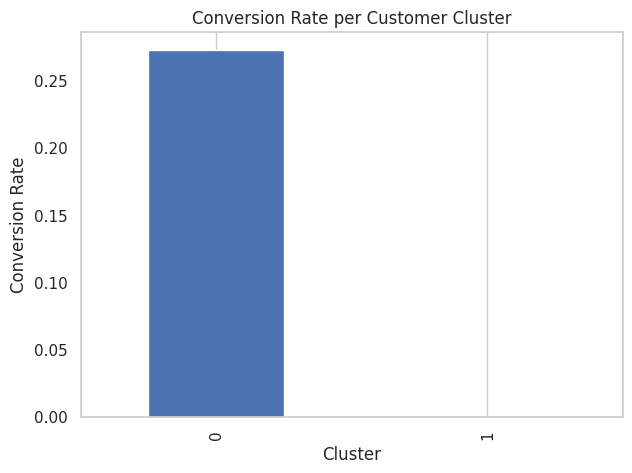

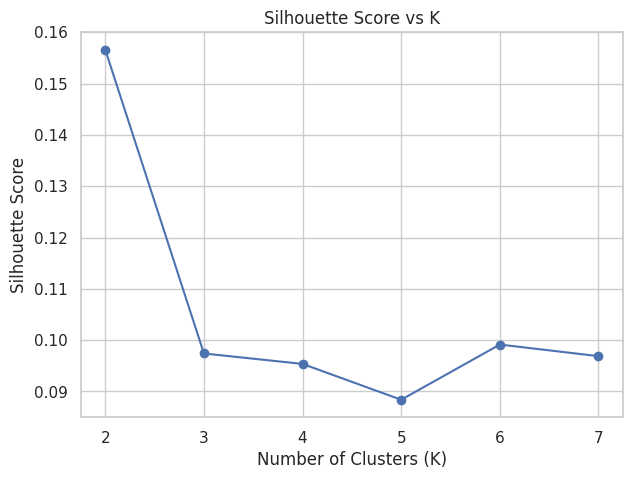


Step 5: Visualizing clusters using 2D PCA...


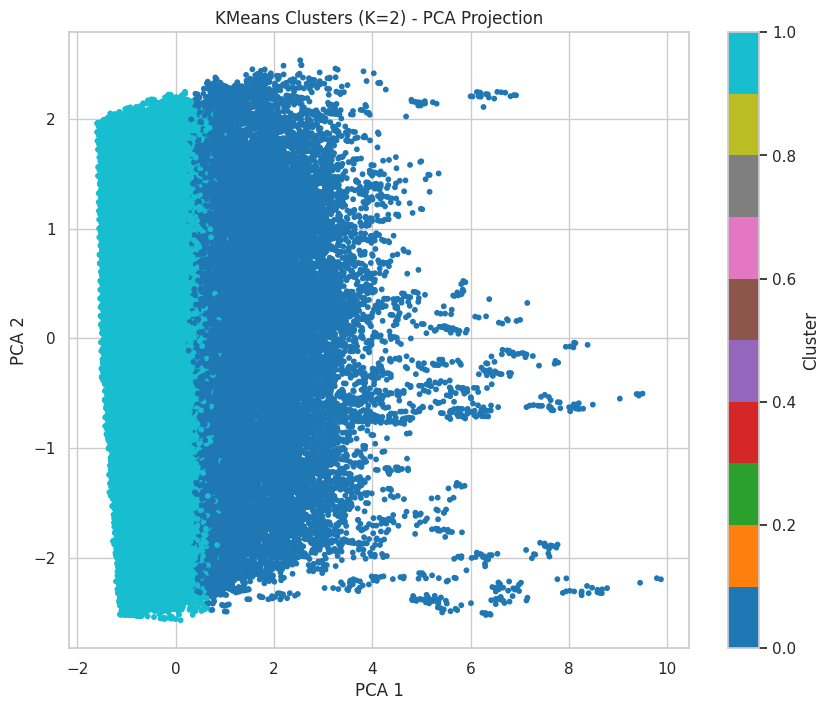

In [28]:
print("Step 1: Preparing features...")

cluster_features = train_df.drop(
    columns=["converted", "price"],
    errors="ignore"
)
print(cluster_features.columns.tolist())

from sklearn.base import clone
cluster_preprocessor = clone(preprocessor_reg)
cluster_data = cluster_preprocessor.fit_transform(cluster_features)

print("Original shape:", cluster_data.shape)

print("\nStep 2: Reducing dimensions using PCA...")

pca = PCA(n_components=30, random_state=42)
cluster_reduced = pca.fit_transform(cluster_data)

print("Reduced shape:", cluster_reduced.shape)

sil_scores = {}

print("\nStep 3: Finding best K using Silhouette Score:\n")

for k in range(2, 8):
    km = MiniBatchKMeans(
        n_clusters=k,
        random_state=42,
        batch_size=2048,
        n_init="auto"
    )

    labels = km.fit_predict(cluster_reduced)
    score = silhouette_score(cluster_reduced, labels)

    sil_scores[k] = score
    print(f"K={k}, Silhouette={score:.4f}")

# Best K
best_k = max(sil_scores, key=sil_scores.get)
print(f"\n✅ Best K = {best_k} (Silhouette = {sil_scores[best_k]:.4f})")


print("\nStep 4: Training final MiniBatchKMeans model...")

final_kmeans = MiniBatchKMeans(
    n_clusters=best_k,
    random_state=42,
    batch_size=2048,
    n_init="auto"
)

cluster_labels = final_kmeans.fit_predict(cluster_reduced)

train_df["Cluster"] = cluster_labels

with open("kmeans_final.pkl", "wb") as f:
    pickle.dump(final_kmeans, f)

with open("pca_cluster.pkl", "wb") as f:
    pickle.dump(pca, f)

print("\nModels saved: kmeans_final.pkl, pca_cluster.pkl")

from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(cluster_reduced, cluster_labels)
sil_final = silhouette_score(cluster_reduced, cluster_labels)

print("\n📊 Final Clustering Evaluation:")
print(f"Silhouette Score       : {sil_final:.4f}")
print(f"Davies-Bouldin Index   : {db_index:.4f}")
print(f"Number of Clusters     : {best_k}")


# MLFLOW LOGGING — CLUSTERING (DAGsHub SAFE)

import mlflow
import mlflow.sklearn

with mlflow.start_run(
    run_name="Clustering_Pipeline",
    nested=True   # ✅ REQUIRED
):
    mlflow.log_metric("silhouette_score", sil_final)
    mlflow.log_metric("davies_bouldin", db_index)
    mlflow.log_param("num_clusters", best_k)

    mlflow.sklearn.log_model(
        sk_model=final_kmeans,
        artifact_path="kmeans",
        registered_model_name="KMeans_Clustering"
    )

print("✅ Clustering model logged to MLflow")


print("\n📌 Cluster Profiling (Behavioral & Revenue Metrics):")

cluster_profile = (
    train_df
    .groupby("Cluster")
    .agg({
        "price": "mean",
        "order": "mean",
        "page": "mean",
        "converted": "mean"
    })
    .rename(columns={
        "price": "Avg Price",
        "order": "Avg Click Order",
        "page": "Avg Page Depth",
        "converted": "Conversion Rate"
    })
)

print(cluster_profile)

cluster_profile["Conversion Rate"].plot(
    kind="bar",
    title="Conversion Rate per Customer Cluster",
    figsize=(7,5)
)
plt.ylabel("Conversion Rate")
plt.xlabel("Cluster")
plt.grid(axis="y")
plt.show()


plt.figure(figsize=(7,5))
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o')
plt.title("Silhouette Score vs K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

print("\nStep 5: Visualizing clusters using 2D PCA...")

pca_2 = PCA(n_components=2)
pca_2d = pca_2.fit_transform(cluster_reduced)

plt.figure(figsize=(10,8))
plt.scatter(pca_2d[:,0], pca_2d[:,1], c=cluster_labels, cmap="tab10", s=10)
plt.title(f"KMeans Clusters (K={best_k}) - PCA Projection")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()


Save Models & Artifacts

In [29]:
# ======================================================
# 🔐 REPRODUCIBILITY
# ======================================================
import numpy as np
np.random.seed(42)

import os
import joblib

# Create artifacts directory
os.makedirs("/content/artifacts", exist_ok=True)


# ======================================================
# 🔹 SAVE BEST CLASSIFICATION PIPELINE
# ======================================================

# Save trained SMOTE + preprocessing + model pipeline
joblib.dump(
    best_classifier_pipe,
    "/content/artifacts/classification_pipeline.pkl"
)

# Save best classifier name (VERY useful for Streamlit / reports)
with open("/content/artifacts/best_classifier_name.txt", "w") as f:
    f.write(best_model_name)


# ======================================================
# 🔹 SAVE BEST REGRESSION PIPELINE (FIXED ❗)
# ======================================================

# IMPORTANT: use regression results only
reg_results_df = pd.DataFrame(regression_results).T

best_reg_name = reg_results_df["R2"].idxmax()
from sklearn.base import clone
best_reg_model = clone(regressors[best_reg_name])

best_regression_pipe = Pipeline([
    ("preprocess", preprocessor_reg),
    ("model", best_reg_model)
])

# Train best regression model
best_regression_pipe.fit(X_train_reg, y_train_reg)

# Save trained regression pipeline
joblib.dump(
    best_regression_pipe,
    "/content/artifacts/regression_pipeline.pkl"
)


# ======================================================
# 🔹 SAVE CLUSTERING MODELS
# ======================================================

joblib.dump(final_kmeans, "/content/artifacts/kmeans.pkl")
joblib.dump(pca, "/content/artifacts/pca.pkl")

joblib.dump(cluster_preprocessor, "/content/artifacts/cluster_preprocessor.pkl")



# ======================================================
# 🔹 SAVE DATA SNAPSHOTS
# ======================================================

train_df.to_csv(
    "/content/artifacts/train_with_clusters.csv",
    index=False
)

test_df.to_csv(
    "/content/artifacts/test_cleaned.csv",
    index=False
)


# ======================================================
# ✅ FINAL CONFIRMATION
# ======================================================

print("✅ All trained models & artifacts saved successfully!")
print("📁 Location: /content/artifacts/")
print(f"🏆 Best Classifier : {best_model_name}")
print(f"📈 Best Regressor  : {best_reg_name}")


✅ All trained models & artifacts saved successfully!
📁 Location: /content/artifacts/
🏆 Best Classifier : Logistic Regression
📈 Best Regressor  : Linear Regression


In [ ]:
import shutil

shutil.make_archive(
    "/content/artifacts",
    'zip',
    "/content/artifacts"
)


'/content/artifacts.zip'

In [ ]:
from google.colab import files
files.download("/content/artifacts.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>